**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [788]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
import seaborn as sns
from geopy.distance import vincenty

In [789]:
data = pd.read_csv('data/Kobe.csv')

In [790]:
kobe_df = data[~np.isnan(data['shot_made_flag'])]
kobe_df = kobe_df.drop(['team_id', 'team_name'], axis = 1)

In [791]:
# matchup and opponent teams compare
kobe_df['matchup'] = kobe_df['matchup'].str.replace('vs.','@')
match_opp_df = kobe_df[['matchup','opponent']]
match_opp_df['matchup_2'] = match_opp_df['matchup'].str.replace('LAL @ ','')
match_opp_df['check_equalty'] = match_opp_df['opponent'].str.lower() == match_opp_df['matchup_2'].str.lower()
match_opp_df[match_opp_df['check_equalty'].astype(str).str.contains('False')].groupby(['opponent', 'matchup_2']).groups

# remove matchup because matchup and opponents are the same
kobe_df = kobe_df.drop(['matchup'], axis = 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [792]:
#shots type compare
shots_type_df = kobe_df[['action_type','combined_shot_type']]
shots_type_df['concate_shots'] = shots_type_df[['action_type','combined_shot_type']].astype(str).sum(axis=1)

#shots_type_df['concate_shots'].nunique()
#shots_type_df['action_type'].nunique()

# remove action_type because colums action_type and combined_shot_type have the same meaning
kobe_df = kobe_df.drop(['action_type'], axis = 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [793]:
# remove other usless columns
kobe_df = kobe_df.drop(['shot_zone_range'], axis = 1)
#kobe_df = kobe_df.drop(['shot_id'], axis = 1)
#kobe_df = kobe_df.drop(['game_event_id'], axis = 1)
kobe_df = kobe_df.drop(['shot_type'], axis = 1)
#kobe_df = kobe_df.drop(['lat'], axis = 1)
#kobe_df = kobe_df.drop(['lon'], axis = 1)
#kobe_df = kobe_df.drop(['game_date'], axis = 1)

In [794]:
def get_woe_v1(kobe_df, col, target_col):
    all_good = len(kobe_df[kobe_df[target_col] == 1][col])
    all_bad = len(kobe_df[kobe_df[target_col] == 0][col])
    odds_series = (
        kobe_df[kobe_df[target_col] == 1][col].value_counts()
        /
        kobe_df[kobe_df[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    kobe_df[col + '_woe'] = kobe_df[col].apply(category_woe_dict.get)
    return kobe_df

In [795]:
# build counts
columns_to_get_counts = [
    'combined_shot_type',
    'season',
    'shot_zone_area',
    'shot_zone_basic',
    'game_date',
    'opponent',
]
    
for col_get_prob in columns_to_get_counts:
    kobe_df = get_woe_v1(kobe_df, col_get_prob, 'shot_made_flag')

In [796]:
 woe_columns = [
    col for col in kobe_df.columns.tolist()
    if col not in set(
        [
            'combined_shot_type',
            'season',
            'shot_zone_area',
            'shot_zone_basic',
            'game_date',
            'opponent',
        ]
    )
]
kobe_df_f = kobe_df[woe_columns]

In [797]:
#kobe_df_f.game_date_woe.value_counts
#kobe_df_f.isna().sum()
kobe_df_f.fillna(0, inplace=True)
kobe_df_f = kobe_df_f.astype(int)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [798]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(kobe_df_f, test_size=0.2, random_state=42)

In [799]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [800]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer

num_attribs = train_set.columns.drop(["shot_made_flag"])

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
])

In [801]:
X_train = train_set.drop("shot_made_flag", axis=1)
y_train = train_set["shot_made_flag"].copy()

X_test = test_set.drop("shot_made_flag", axis=1)
y_test = test_set["shot_made_flag"].copy()

In [802]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

In [803]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(X_train_prepared, y_train)
y_pred = lin_reg.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.4767674299411664

In [804]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [805]:
_iteration_cols = train_set.columns.drop('shot_made_flag')

In [806]:
def get_formula(_cols):
    return 'shot_made_flag ~ ' + " + ".join(_cols)

In [807]:
lm = smf.ols(get_formula(_iteration_cols), train_set).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.47693155353962624
R^2: 0.08024288859531858


In [808]:
lm_res = lm.summary()
lm_res.tables[1]

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1633: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.615e-05,2.87e-05,1.954,0.051,-1.81e-07,0.000
game_event_id,7.379e-05,0.000,0.577,0.564,-0.000,0.000
game_id,-4.83e-09,1.44e-09,-3.356,0.001,-7.65e-09,-2.01e-09
lat,-0.0045,0.012,-0.383,0.702,-0.028,0.019
loc_x,1.431e-05,3.04e-05,0.471,0.638,-4.52e-05,7.38e-05
loc_y,0.0002,8.6e-05,1.890,0.059,-6.01e-06,0.000
lon,-0.0066,0.003,-1.954,0.051,-0.013,2.14e-05
minutes_remaining,0.0038,0.002,2.367,0.018,0.001,0.007
period,-0.0181,0.016,-1.134,0.257,-0.050,0.013
playoffs,0.0908,0.025,3.565,0.000,0.041,0.141


In [809]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [810]:
xdf = train_set.copy()
y = xdf['shot_made_flag']
xdf.drop(columns = ['shot_made_flag'])
X = xdf.values

In [811]:
rg = Ridge(alpha=1000).fit(X, y)
print(rg.intercept_)

0.09495019913825031


In [812]:
rg = Lasso().fit(X, y)
print(rg.intercept_)

0.5316195762679892


In [813]:
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost

xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(X_train, y_train)
y_train_predict = xgb.predict_proba(X_train)[:, 1]
y_test_predict = xgb.predict_proba(X_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.73
Test:  0.63


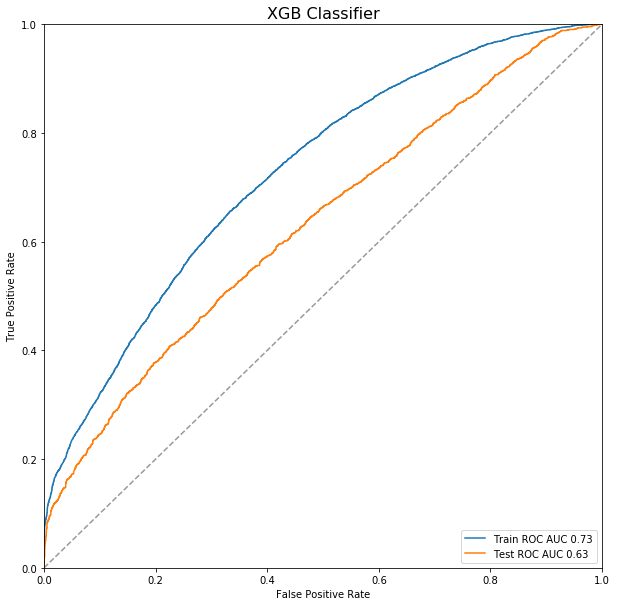

In [814]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

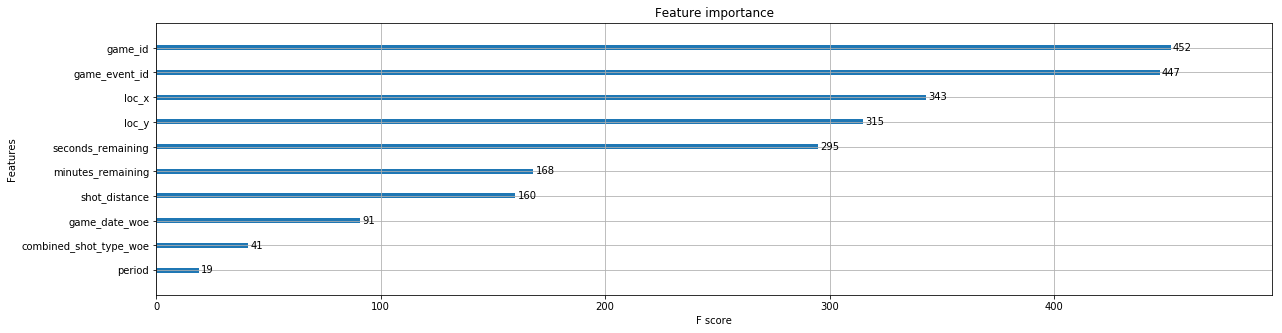

In [787]:
matplotlib.rcParams['figure.figsize'] = (20, 5)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')